In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

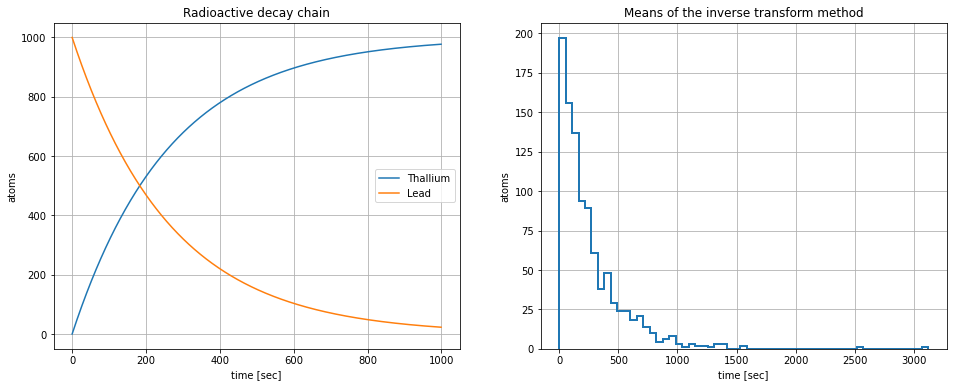

In [2]:
# initial parameters
N = 1000
step = 1 # sec
tau = 3.052 * 60 # sec

# probability function
def p(t):
    return 1 - pow(2, -t/tau)

# inverse function
def inv_p(y):
    return -tau * np.log2(1 - y)

# axis computation
time = np.arange(0, 1000, step)
y = p(time)
atoms = np.random.random(1000)
t = inv_p(atoms)

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

ax1.plot(time, N * y) # probability of N atoms
ax1.plot(time, N * (1- y))
ax1.set_xlabel('time [sec]')
ax1.set_ylabel('atoms')
ax1.set_title('Radioactive decay chain')
ax1.legend(['Thallium', 'Lead'])
ax1.grid()

ax2.hist(t, histtype='step', bins='auto', linewidth=2)
ax2.set_xlabel('time [sec]')
ax2.set_ylabel('atoms')
ax2.set_title('Means of the inverse transform method')
ax2.grid()

plt.show()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

Using the hit/miss method 100 times: 1.3479940000000001 +- 0.008395877798062577

Using the mean value method 100 times: 1.3479940000000001 +- 4.470348358154297e-08

In conclusion, the mean value method is extremely more precise, as expected.


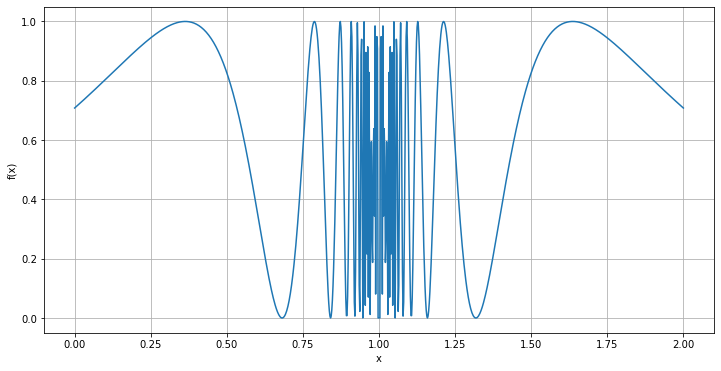

In [3]:
# function f(x)
def f(x):
    return np.sin(1 / (1 - x)) ** 2

# hit/miss method
def hit_miss(N):
    count = 0
    for i in range(N):
        x = 2 * np.random.random() # x-range [0,2]
        y = np.random.random() # y-range [0,1]
        if y < f(x):
            count += 1
    return 2 * count / N 

# mean value method
def mean_value(N):
    summation = 0
    for i in np.linspace(0, 2, N):
        summation += f(i)
    return 2 * summation / N
    
# plot
N = 1000
x = np.linspace(0, 2, N)

# plot of f(x)
fig, ax1 = plt.subplots(figsize=[12, 6])
ax1.plot(x, f(x))
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.grid()

# hit/miss method
N = 100
samples = 10000
myresults = []
for i in range(N):
    myresults.append(hit_miss(samples))
mean = np.mean(myresults)
std = np.std(myresults)
print('Using the hit/miss method', N, 'times:', mean, '+-', std)

# mean value method
N = 100
samples = 10000
myresults = []
for i in range(N):
    myresults.append(mean_value(samples))
I = np.mean(myresults) # mean
I2 = np.mean(np.array(myresults)**2)
sigma2 = I2 - I**2
sigma = np.sqrt(sigma2)

print('\nUsing the mean value method', N, 'times:', mean, '+-', sigma)
print('\nIn conclusion, the mean value method is extremely more precise, as expected.')

plt.show()

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [7]:
# function f(x,y) 2D
def f2D(x, y):
    if x**2 + y**2 <= 1:
        return 1
    else: 
        return 0
    
# integration function 2D
def hitmiss2D(N):
    count = 0
    for i in range(N):
        x = 2 * np.random.random() - 1 # x-range [-1,1]
        y = 2 * np.random.random() - 1 # y-range [-1,1]
        count += f2D(x,y)
    return 4 * count / N
    
# function f(x,y) 10D
def f10D(x):
    if np.sum(np.square(x)) <= 1:
        return 1
    else: 
        return 0
    
# integration function 10D
def hitmiss10D(N):
    count = 0
    for i in range(N):
        x = 2 * np.random.random(10) - 1 # xs-range [-1,1]
        count += f10D(x)
    return 2 ** 10 * count / N

# 2D
N = 10000
print('The area of the 2D - circle is:', hitmiss2D(N))

# 10D
N = 10000
print('The area of the 10D - circle is:', hitmiss10D(N))

The area of the 2D - circle is: 3.1532
The area of the 10D - circle is: 2.6624


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [8]:
# function f(x)
def f(x):
    return pow(x, -0.5) / (np.exp(x) + 1)

# weight function 
def w(x):
    return 1 / pow(x, 0.5)

# number of sapmles
N = 100000

# generate a distribution  of random points according to the weight function
y = np.random.uniform(0.0001, 1, N)**2

# computing manually the integral in [0,1] of w(x)
w_int = 2

# final integral - importance sampling method
I = 1 / N * np.sum(f(y) / w(y)) * w_int
print('The value of the integral is:', I)


The value of the integral is: 0.8377447159559468
